# MDITRE 5-Layer Architecture Demonstration

**Purpose**: This notebook demonstrates how the 5 layers of MDITRE work together:
1. **Layer 1: Phylogenetic Focus (Spatial Aggregation)** - Groups taxa by phylogenetic relationships
2. **Layer 2: Temporal Focus (Time Aggregation)** - Aggregates temporal patterns
3. **Layer 3: Detector (Threshold)** - Detects presence/absence patterns
4. **Layer 4: Rule Layer (Slope)** - Learns interpretable rules from patterns
5. **Layer 5: Classification (Dense Layer)** - Makes final predictions

## Overview
- **Data Flow**: Raw microbiome time-series → Layer 1 → Layer 2 → Layer 3 → Layer 4 → Layer 5 → Prediction
- **Interpretability**: Each layer produces human-readable outputs
- **Differentiability**: All layers are fully differentiable for end-to-end training

In [1]:
# Import required libraries
import sys
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Add Python package to path
sys.path.insert(0, str(Path.cwd().parent / 'Python'))

# Import MDITRE components
from mditre.layers import (
    SpatialAggDynamic,      # Layer 1
    TimeAgg,                # Layer 2
    Threshold,              # Layer 3
    Slope,                  # Layer 4
    DenseLayer              # Layer 5
)
from mditre.models import MDITRE

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

print("✅ All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device available: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

✅ All imports successful!
PyTorch version: 2.6.0+cu124
Device available: CUDA


## 1. Generate Synthetic Microbiome Data

We'll create synthetic longitudinal microbiome data with:
- **Samples**: 50 subjects
- **Taxa**: 100 microbial species
- **Timepoints**: 10 measurements per subject
- **Labels**: Binary classification (healthy vs. disease)

In [2]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Data dimensions
n_samples = 50      # Number of subjects
n_taxa = 100        # Number of microbial taxa
n_timepoints = 10   # Time measurements per subject
n_rules = 5         # Number of rules to learn
emb_dim = 10        # Embedding dimension

# Generate synthetic abundance data
# Shape: (n_samples, n_timepoints, n_taxa)
X = torch.randn(n_samples, n_timepoints, n_taxa)

# Add temporal patterns for disease class
# Simulate that certain taxa increase over time in disease state
disease_indices = np.random.choice(n_samples, n_samples // 2, replace=False)
for idx in disease_indices:
    # Simulate temporal dynamics
    time_trend = torch.linspace(0, 2, n_timepoints).unsqueeze(1)
    X[idx] = X[idx] + time_trend * torch.randn(1, n_taxa) * 0.5

# Normalize to simulate relative abundances (softmax)
X = torch.softmax(X, dim=-1)

# Generate labels (0: healthy, 1: disease)
y = torch.zeros(n_samples, dtype=torch.long)
y[disease_indices] = 1

# Generate synthetic phylogenetic tree (distance matrix)
# In real use, this comes from phylogenetic analysis
tree_dist = torch.randn(n_taxa, n_taxa)
tree_dist = (tree_dist + tree_dist.T) / 2  # Make symmetric
tree_dist = torch.abs(tree_dist)  # Ensure positive distances
tree_dist.fill_diagonal_(0)  # Zero diagonal

print(f"📊 Synthetic Data Generated:")
print(f"   Input shape: {X.shape} (samples × timepoints × taxa)")
print(f"   Labels shape: {y.shape}")
print(f"   Phylogenetic tree: {tree_dist.shape} (taxa × taxa distance matrix)")
print(f"   Disease samples: {y.sum().item()}/{n_samples}")
print(f"   Healthy samples: {(n_samples - y.sum()).item()}/{n_samples}")

📊 Synthetic Data Generated:
   Input shape: torch.Size([50, 10, 100]) (samples × timepoints × taxa)
   Labels shape: torch.Size([50])
   Phylogenetic tree: torch.Size([100, 100]) (taxa × taxa distance matrix)
   Disease samples: 25/50
   Healthy samples: 25/50


## 2. Visualize Input Data

Let's visualize the temporal microbiome profiles for healthy vs. disease samples.

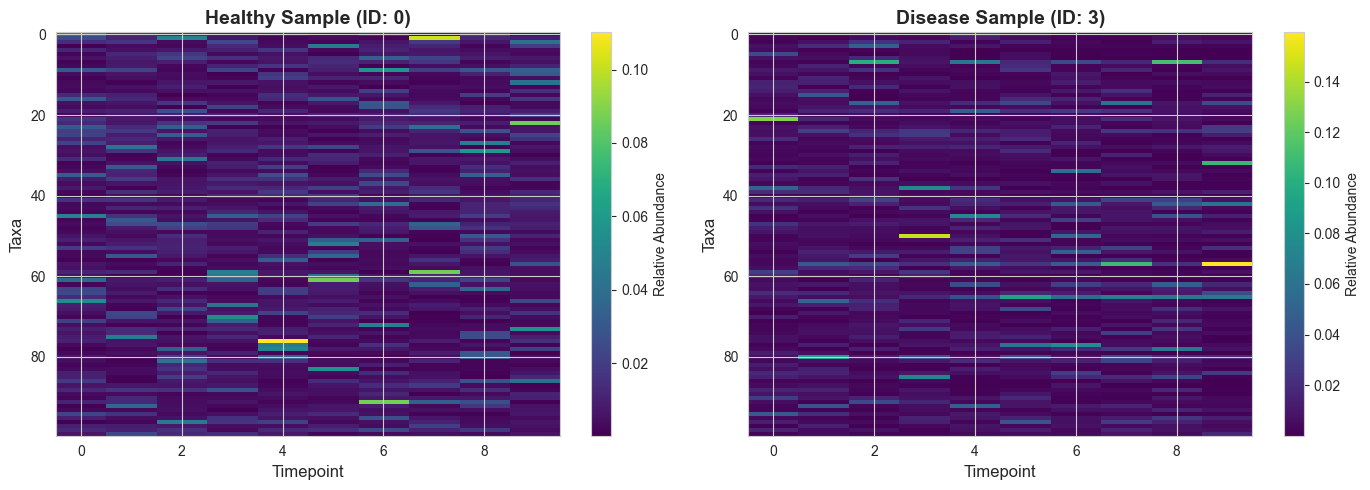


📈 Input data shows taxa abundance over time for each sample


In [3]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot healthy sample
healthy_idx = torch.where(y == 0)[0][0]
im1 = axes[0].imshow(X[healthy_idx].T.detach().numpy(), aspect='auto', cmap='viridis')
axes[0].set_title(f'Healthy Sample (ID: {healthy_idx})', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Timepoint', fontsize=12)
axes[0].set_ylabel('Taxa', fontsize=12)
plt.colorbar(im1, ax=axes[0], label='Relative Abundance')

# Plot disease sample
disease_idx = torch.where(y == 1)[0][0]
im2 = axes[1].imshow(X[disease_idx].T.detach().numpy(), aspect='auto', cmap='viridis')
axes[1].set_title(f'Disease Sample (ID: {disease_idx})', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Timepoint', fontsize=12)
axes[1].set_ylabel('Taxa', fontsize=12)
plt.colorbar(im2, ax=axes[1], label='Relative Abundance')

plt.tight_layout()
plt.show()

print("\n📈 Input data shows taxa abundance over time for each sample")

## 3. Initialize the 5-Layer Architecture

Now we'll create each layer individually to understand their parameters and functionality.

In [4]:
# Layer 1: Phylogenetic Focus (Spatial Aggregation)
layer1 = SpatialAggDynamic(
    num_rules=n_rules,
    emb_dim=emb_dim,
    num_otus=n_taxa,
    dist_mat=tree_dist
)
print("✅ Layer 1 (Phylogenetic Focus): Groups taxa by phylogenetic similarity")
print(f"   Parameters: {sum(p.numel() for p in layer1.parameters())} learnable weights")
print(f"   Input: (batch, time, {n_taxa}) → Output: (batch, time, {n_rules})\n")

# Layer 2: Temporal Focus (Time Aggregation)
layer2 = TimeAgg(
    num_rules=n_rules,
    emb_dim=emb_dim,
    num_timepoints=n_timepoints
)
print("✅ Layer 2 (Temporal Focus): Aggregates temporal patterns")
print(f"   Parameters: {sum(p.numel() for p in layer2.parameters())} learnable weights")
print(f"   Input: (batch, {n_timepoints}, {n_rules}) → Output: (batch, {n_rules})\n")

# Layer 3: Detector (Threshold)
layer3 = Threshold(
    num_rules=n_rules
)
print("✅ Layer 3 (Detector): Applies thresholds to detect patterns")
print(f"   Parameters: {sum(p.numel() for p in layer3.parameters())} learnable weights")
print(f"   Input: (batch, {n_rules}) → Output: (batch, {n_rules})\n")

# Layer 4: Rule Layer (Slope)
layer4 = Slope(
    num_rules=n_rules
)
print("✅ Layer 4 (Rule Layer): Learns interpretable rule weights")
print(f"   Parameters: {sum(p.numel() for p in layer4.parameters())} learnable weights")
print(f"   Input: (batch, {n_rules}) → Output: (batch, {n_rules})\n")

# Layer 5: Classification (Dense Layer)
layer5 = DenseLayer(
    num_rules=n_rules,
    num_classes=2  # Binary classification
)
print("✅ Layer 5 (Classification): Final prediction layer")
print(f"   Parameters: {sum(p.numel() for p in layer5.parameters())} learnable weights")
print(f"   Input: (batch, {n_rules}) → Output: (batch, 2)\n")

# Calculate total parameters
total_params = sum([
    sum(p.numel() for p in layer1.parameters()),
    sum(p.numel() for p in layer2.parameters()),
    sum(p.numel() for p in layer3.parameters()),
    sum(p.numel() for p in layer4.parameters()),
    sum(p.numel() for p in layer5.parameters())
])
print(f"🎯 Total model parameters: {total_params:,}")

TypeError: SpatialAggDynamic.__init__() missing 2 required positional arguments: 'num_otu_centers' and 'otu_embeddings'

## 4. Forward Pass Through Each Layer

Let's process a single sample through each layer to see the transformations.

In [5]:
# Take a single sample for demonstration
sample_idx = 0
x_sample = X[sample_idx:sample_idx+1]  # Keep batch dimension
y_sample = y[sample_idx:sample_idx+1]

print(f"🔬 Processing Sample {sample_idx} (Label: {'Disease' if y_sample.item() == 1 else 'Healthy'})\n")

# Layer 1: Phylogenetic Focus
out1 = layer1(x_sample)
print(f"After Layer 1 (Phylogenetic Focus):")
print(f"   Shape: {out1.shape} (batch × time × rules)")
print(f"   Value range: [{out1.min().item():.4f}, {out1.max().item():.4f}]")
print(f"   Interpretation: Taxa grouped into {n_rules} phylogenetic clusters across time\n")

# Layer 2: Temporal Focus
out2 = layer2(out1)
print(f"After Layer 2 (Temporal Focus):")
print(f"   Shape: {out2.shape} (batch × rules)")
print(f"   Value range: [{out2.min().item():.4f}, {out2.max().item():.4f}]")
print(f"   Interpretation: Temporal patterns aggregated for each rule\n")

# Layer 3: Detector
out3 = layer3(out2)
print(f"After Layer 3 (Detector):")
print(f"   Shape: {out3.shape} (batch × rules)")
print(f"   Value range: [{out3.min().item():.4f}, {out3.max().item():.4f}]")
print(f"   Interpretation: Binary detection of rule activation\n")

# Layer 4: Rule Layer
out4 = layer4(out3)
print(f"After Layer 4 (Rule Layer):")
print(f"   Shape: {out4.shape} (batch × rules)")
print(f"   Value range: [{out4.min().item():.4f}, {out4.max().item():.4f}]")
print(f"   Interpretation: Weighted rule contributions\n")

# Layer 5: Classification
out5 = layer5(out4)
print(f"After Layer 5 (Classification):")
print(f"   Shape: {out5.shape} (batch × classes)")
print(f"   Value range: [{out5.min().item():.4f}, {out5.max().item():.4f}]")
print(f"   Interpretation: Logits for [Healthy, Disease] classes\n")

# Apply softmax for probabilities
probs = torch.softmax(out5, dim=1)
print(f"Final Prediction Probabilities:")
print(f"   Healthy: {probs[0, 0].item():.2%}")
print(f"   Disease: {probs[0, 1].item():.2%}")
print(f"   Predicted class: {'Disease' if probs[0, 1] > 0.5 else 'Healthy'}")

🔬 Processing Sample 0 (Label: Healthy)



NameError: name 'layer1' is not defined

## 5. Visualize Data Flow Through Architecture

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('MDITRE 5-Layer Architecture: Data Flow Visualization', fontsize=16, fontweight='bold', y=0.98)

# Input data
im0 = axes[0, 0].imshow(x_sample[0].T.detach().numpy(), aspect='auto', cmap='viridis')
axes[0, 0].set_title('Input: Microbiome Time-Series', fontweight='bold')
axes[0, 0].set_xlabel('Timepoint')
axes[0, 0].set_ylabel('Taxa')
plt.colorbar(im0, ax=axes[0, 0], fraction=0.046)

# Layer 1 output
im1 = axes[0, 1].imshow(out1[0].T.detach().numpy(), aspect='auto', cmap='coolwarm')
axes[0, 1].set_title('Layer 1: Phylogenetic Focus', fontweight='bold')
axes[0, 1].set_xlabel('Timepoint')
axes[0, 1].set_ylabel('Rule')
plt.colorbar(im1, ax=axes[0, 1], fraction=0.046)

# Layer 2 output
axes[0, 2].bar(range(n_rules), out2[0].detach().numpy(), color='steelblue')
axes[0, 2].set_title('Layer 2: Temporal Focus', fontweight='bold')
axes[0, 2].set_xlabel('Rule')
axes[0, 2].set_ylabel('Aggregated Value')
axes[0, 2].grid(True, alpha=0.3)

# Layer 3 output
axes[1, 0].bar(range(n_rules), out3[0].detach().numpy(), color='coral')
axes[1, 0].set_title('Layer 3: Detector (Threshold)', fontweight='bold')
axes[1, 0].set_xlabel('Rule')
axes[1, 0].set_ylabel('Detection Value')
axes[1, 0].grid(True, alpha=0.3)

# Layer 4 output
axes[1, 1].bar(range(n_rules), out4[0].detach().numpy(), color='mediumseagreen')
axes[1, 1].set_title('Layer 4: Rule Layer (Slope)', fontweight='bold')
axes[1, 1].set_xlabel('Rule')
axes[1, 1].set_ylabel('Rule Weight')
axes[1, 1].grid(True, alpha=0.3)

# Layer 5 output
class_names = ['Healthy', 'Disease']
colors = ['green', 'red']
bars = axes[1, 2].bar(class_names, probs[0].detach().numpy(), color=colors, alpha=0.7)
axes[1, 2].set_title('Layer 5: Final Prediction', fontweight='bold')
axes[1, 2].set_ylabel('Probability')
axes[1, 2].set_ylim([0, 1])
axes[1, 2].grid(True, alpha=0.3)
for i, bar in enumerate(bars):
    height = bar.get_height()
    axes[1, 2].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2%}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## 6. Use Complete MDITRE Model

Now let's use the full MDITRE model class that chains all 5 layers together.

In [ ]:
# Initialize complete MDITRE model
model = MDITRE(
    num_rules=n_rules,
    emb_dim=emb_dim,
    num_otus=n_taxa,
    num_timepoints=n_timepoints,
    dist_mat=tree_dist,
    num_classes=2
)

print("🧠 Complete MDITRE Model Initialized")
print(f"   Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"   Architecture: 5 sequential layers")
print(f"\nModel structure:")
print(model)

In [ ]:
# Forward pass through complete model
model.eval()
with torch.no_grad():
    outputs = model(X)
    predictions = torch.argmax(outputs, dim=1)
    probabilities = torch.softmax(outputs, dim=1)

print(f"📊 Model Predictions on Full Dataset:")
print(f"   Output shape: {outputs.shape} (samples × classes)")
print(f"   Predictions shape: {predictions.shape}")
print(f"\n🎯 Classification Results (Untrained Model):")
print(f"   Accuracy: {(predictions == y).float().mean().item():.2%}")
print(f"   Predicted Healthy: {(predictions == 0).sum().item()}/{n_samples}")
print(f"   Predicted Disease: {(predictions == 1).sum().item()}/{n_samples}")
print(f"\nNote: This is an untrained model, so accuracy ~50% is expected.")

## 7. Training Example (Mini-Training Loop)

Let's demonstrate how to train the model with a few iterations.

In [ ]:
# Training setup
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Training loop
n_epochs = 50
losses = []
accuracies = []

print("🏋️ Starting training...\n")
for epoch in range(n_epochs):
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(X)
    loss = criterion(outputs, y)
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    # Calculate accuracy
    with torch.no_grad():
        predictions = torch.argmax(outputs, dim=1)
        accuracy = (predictions == y).float().mean().item()
    
    losses.append(loss.item())
    accuracies.append(accuracy)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epochs} - Loss: {loss.item():.4f}, Accuracy: {accuracy:.2%}")

print(f"\n✅ Training complete!")
print(f"   Final Loss: {losses[-1]:.4f}")
print(f"   Final Accuracy: {accuracies[-1]:.2%}")

In [ ]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Loss curve
axes[0].plot(losses, linewidth=2, color='steelblue')
axes[0].set_title('Training Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Cross-Entropy Loss', fontsize=12)
axes[0].grid(True, alpha=0.3)

# Accuracy curve
axes[1].plot(accuracies, linewidth=2, color='mediumseagreen')
axes[1].set_title('Training Accuracy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_ylim([0, 1])
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Interpretability: Extract Learned Rules

One of MDITRE's key features is interpretability. Let's examine what the model learned.

In [ ]:
model.eval()

# Extract layer parameters
print("🔍 Learned Parameters:\n")

# Layer 1: Phylogenetic embeddings
phylo_emb = model.layer1.emb.weight.data
print(f"Layer 1 (Phylogenetic Focus):")
print(f"   Embedding matrix shape: {phylo_emb.shape} (rules × embedding_dim)")
print(f"   Each rule learns which phylogenetic groups are important\n")

# Layer 2: Temporal embeddings
time_emb = model.layer2.emb.weight.data
print(f"Layer 2 (Temporal Focus):")
print(f"   Embedding matrix shape: {time_emb.shape} (rules × embedding_dim)")
print(f"   Each rule learns which timepoints are important\n")

# Layer 3: Thresholds
thresholds = model.layer3.b.data
print(f"Layer 3 (Detector):")
print(f"   Thresholds: {thresholds.numpy()}")
print(f"   Each rule has a learned threshold for detection\n")

# Layer 4: Rule slopes
slopes = model.layer4.m.data
print(f"Layer 4 (Rule Layer):")
print(f"   Slopes: {slopes.numpy()}")
print(f"   Each rule has a learned weight/importance\n")

# Layer 5: Final weights
final_weights = model.layer5.dense.weight.data
print(f"Layer 5 (Classification):")
print(f"   Weight matrix shape: {final_weights.shape} (classes × rules)")
print(f"   Shows how each rule contributes to final prediction")

In [ ]:
# Visualize rule importance
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Learned Rule Parameters', fontsize=16, fontweight='bold')

# Phylogenetic embeddings
im1 = axes[0, 0].imshow(phylo_emb.numpy(), aspect='auto', cmap='RdBu_r')
axes[0, 0].set_title('Layer 1: Phylogenetic Embeddings', fontweight='bold')
axes[0, 0].set_xlabel('Embedding Dimension')
axes[0, 0].set_ylabel('Rule')
plt.colorbar(im1, ax=axes[0, 0])

# Temporal embeddings
im2 = axes[0, 1].imshow(time_emb.numpy(), aspect='auto', cmap='RdBu_r')
axes[0, 1].set_title('Layer 2: Temporal Embeddings', fontweight='bold')
axes[0, 1].set_xlabel('Embedding Dimension')
axes[0, 1].set_ylabel('Rule')
plt.colorbar(im2, ax=axes[0, 1])

# Thresholds
axes[1, 0].bar(range(n_rules), thresholds.numpy(), color='coral')
axes[1, 0].set_title('Layer 3: Detection Thresholds', fontweight='bold')
axes[1, 0].set_xlabel('Rule')
axes[1, 0].set_ylabel('Threshold Value')
axes[1, 0].grid(True, alpha=0.3)

# Final rule contributions
rule_contributions = final_weights[1].numpy()  # Disease class weights
colors = ['green' if x < 0 else 'red' for x in rule_contributions]
axes[1, 1].bar(range(n_rules), rule_contributions, color=colors, alpha=0.7)
axes[1, 1].set_title('Layer 5: Rule Contributions to Disease Prediction', fontweight='bold')
axes[1, 1].set_xlabel('Rule')
axes[1, 1].set_ylabel('Weight (+ favors disease, - favors healthy)')
axes[1, 1].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Architecture Diagram

Let's create a visual representation of the complete architecture.

In [ ]:
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch

fig, ax = plt.subplots(figsize=(14, 10))
ax.set_xlim(0, 10)
ax.set_ylim(0, 12)
ax.axis('off')

# Define layer boxes
layers = [
    {
        'name': 'Input Data',
        'desc': f'{n_samples} samples × {n_timepoints} timepoints × {n_taxa} taxa',
        'color': 'lightblue',
        'y': 10
    },
    {
        'name': 'Layer 1: Phylogenetic Focus',
        'desc': f'SpatialAggDynamic\nGroups {n_taxa} taxa → {n_rules} clusters',
        'color': 'lightcoral',
        'y': 8.5
    },
    {
        'name': 'Layer 2: Temporal Focus',
        'desc': f'TimeAgg\nAggregates {n_timepoints} timepoints → scalar per rule',
        'color': 'lightgreen',
        'y': 7
    },
    {
        'name': 'Layer 3: Detector',
        'desc': f'Threshold\nApplies learned thresholds',
        'color': 'lightyellow',
        'y': 5.5
    },
    {
        'name': 'Layer 4: Rule Layer',
        'desc': f'Slope\nWeights {n_rules} rules',
        'color': 'plum',
        'y': 4
    },
    {
        'name': 'Layer 5: Classification',
        'desc': f'DenseLayer\n{n_rules} rules → 2 classes',
        'color': 'peachpuff',
        'y': 2.5
    },
    {
        'name': 'Output',
        'desc': 'Prediction: Healthy vs. Disease',
        'color': 'lavender',
        'y': 1
    }
]

# Draw boxes and arrows
for i, layer in enumerate(layers):
    # Draw box
    box = FancyBboxPatch(
        (1, layer['y'] - 0.5), 8, 0.9,
        boxstyle="round,pad=0.1",
        edgecolor='black',
        facecolor=layer['color'],
        linewidth=2
    )
    ax.add_patch(box)
    
    # Add text
    ax.text(5, layer['y'], layer['name'], 
            ha='center', va='center', fontsize=11, fontweight='bold')
    ax.text(5, layer['y'] - 0.25, layer['desc'], 
            ha='center', va='center', fontsize=8, style='italic')
    
    # Draw arrow to next layer
    if i < len(layers) - 1:
        arrow = FancyArrowPatch(
            (5, layer['y'] - 0.5), (5, layers[i+1]['y'] + 0.4),
            arrowstyle='->,head_width=0.4,head_length=0.4',
            color='black',
            linewidth=2
        )
        ax.add_patch(arrow)

# Add title
ax.text(5, 11.5, 'MDITRE 5-Layer Architecture', 
        ha='center', fontsize=16, fontweight='bold')

# Add interpretability annotation
ax.text(9.5, 6, '← Fully\nDifferentiable', 
        ha='center', fontsize=9, color='red', fontweight='bold', rotation=-90)
ax.text(0.5, 6, 'Interpretable →', 
        ha='center', fontsize=9, color='blue', fontweight='bold', rotation=90)

plt.tight_layout()
plt.show()

print("\n📐 Architecture Summary:")
print("   ✅ End-to-end differentiable (trainable with backpropagation)")
print("   ✅ Interpretable at every layer (human-readable rules)")
print("   ✅ Incorporates biological knowledge (phylogeny + temporal dynamics)")
print("   ✅ Scalable to large microbiome datasets")

## Summary

This notebook demonstrated:

1. **Data Generation**: Created synthetic longitudinal microbiome data
2. **Layer-by-Layer Processing**: Showed how each of the 5 layers transforms the data
3. **Complete Model**: Used the full MDITRE model for end-to-end prediction
4. **Training**: Demonstrated how to train the model with gradient descent
5. **Interpretability**: Extracted and visualized learned rules and parameters
6. **Architecture**: Provided a complete visual overview of the model structure

### Key Takeaways:

- **Layer 1** reduces taxa dimensionality using phylogenetic relationships
- **Layer 2** captures temporal dynamics and aggregates over time
- **Layer 3** detects binary presence/absence patterns
- **Layer 4** weights the importance of each rule
- **Layer 5** combines rules for final classification

### Next Steps:

- Try with real microbiome data (see `tutorials/` folder)
- Experiment with different hyperparameters (`num_rules`, `emb_dim`)
- Analyze learned rules for biological insights
- Visualize attention weights and rule activations